# Feature evaluation

org: **D4G**  project: **BGCO**  task: **feature evaluation**

data: labeled (engage vs. static) dataset highlighting changes in member engagement (visits per week) between first and year of engagement

## Prep the environment

In [61]:
import pandas as pd  # used to manipulate dataframes
import numpy as np # used to manipulate series

import seaborn as sns  # needed for visualing
import matplotlib.pyplot as plt  # needed for visualing

## Data Wrangling

### Load Data

In [62]:
# read in the dataframe
df_001 = pd.read_csv("D4G_BGCO_Engage_Labeled_v002.csv", encoding = "cp1252")

### Version Control

See sections below for details on how filters were created.

In [63]:
df_002 = df_001.drop(droplist_unique, axis = 1)  # features with no unique values removed

In [64]:
df_003 = df_002.drop(['member_identity', 'active', 
                      'birth_year', 'age', 'grade', 'age_category', 'member_since',
                      'city', 'd4g_valid_postal_code', 'postal_code',
                      'checkin_avg'], 
                     axis = 1)  # redundant features

In [65]:
df_004 = df_003.drop(['member_number', 'd4g_school_id'], axis = 1)  # erroneous aggregation, school_id has many -1

In [66]:
df_005 = df_004.drop(droplist_missing, axis = 1)  # missing values exceed 20%

In [67]:
df_006 = df_005.drop(imbalance, axis = 1)  # where one value count > 82%

### Save Data

In [69]:
df.to_csv("D4G_BGCO_Churn_Labeled_ForEDA_v002.csv", index = False)

## Explore Data

In [68]:
df = df_006

In [50]:
print("The training set has {0} rows and {1} columns".format(df.shape[0], df.shape[1]))

The training set has 2234 rows and 13 columns


In [51]:
df.columns

Index(['d4g_member_id', 'label', 'first_year', 'member_location', 'sex',
       'Y1_Age', 'checkin_total', 'season_most', 'club_km', 'club_min_km',
       'club_min_name', 'diff_club_min', 'Neighborhood'],
      dtype='object')

### Feature Summary

Proposed
* visits per week or month to clubhouse in y1 (find out if being a 'busy' clubhouse is a factor)
* number of programs offered by clubhouse
* when during the week do members visit

Key
* d4g_member_id (primary key)

Behaviour
* label (target feature)
* total number of visits by member in y1
* visits grouped by fall or winter

Service
* first_year: the first year of engagement
* member_location: clubhouse visited

Characteristic
* Y1_Age: age at first_year
* sex
* neighborhood (partial)
* club_km (partial)
* diff_club_min (partial)

Conditional Inclusions
* first_language (only 60% of the dataset) (missing data)
* distance to clubhouse (only 77% of the dataset) (missing data), some of these are erroneous


### Unique Values

Number of unique values, if 1 or less should be removed.

In [19]:
df.nunique()

d4g_member_id              2234
label                         2
first_year                   10
member_number              2106
mem_type                      2
active                        2
member_location               9
city                         41
province                      3
postal_code                1162
d4g_valid_postal_code       640
birth_year                   19
sex                           2
d4g_school_id               180
grade                        13
first_language                8
second_language              10
other_languages               7
ethnic_origin                 1
member_since               1042
last_renewal_date           756
member_type                   0
member_fee_paid_to_date       1
member_fee_outstanding        1
member_fees_total             1
suspended                     2
camper                        2
camp_year                     2
member_identity            2234
subsidy                       1
hear_about                    2
family_i

Create a list of columns with low unique value counts, then remove then from the dataset (df_001 -> df_002)

In [20]:
droplist_unique = [i for i in df.columns if df[i].nunique('label') < 2]
droplist_unique

['ethnic_origin',
 'member_type',
 'member_fee_paid_to_date',
 'member_fee_outstanding',
 'member_fees_total',
 'subsidy']

### Erroneous Aggregation

Special case: Member numbers
* the duplicates in this feature seem to correspond to different members
* thus inclusion erroneously reduces variability, without adding qualifiers

In [11]:
duplicates = df.duplicated('member_number', keep = False)
df_duplicates = df[duplicates]
df_duplicates[['member_number','first_year', 'sex', 'Y1_Age']].sort_values(by = 'member_number').head(6)

,member_number,first_year,sex,Y1_Age
813,00b4a051351b585e1f29ffce2b7ff5d2,2016,F,14
1563,00b4a051351b585e1f29ffce2b7ff5d2,2015,M,7
1299,0810026898d95f0d082b560bd31790e0,2012,F,7
2175,0810026898d95f0d082b560bd31790e0,2009,F,12
1987,0ae5e6b6663e3882cde21f6f71dba9ba,2015,M,14
335,0ae5e6b6663e3882cde21f6f71dba9ba,2009,M,6


### Missing Values

How many features/attributes have missing values? Which ones?
* df_004 used to exclude if missing > 20%

In [30]:
print("A total of ", len(df.columns[df.isnull().any()]), "features have missing values")
print("They are:", df.columns[df.isnull().any()])

A total of  14 features have missing values
They are: Index(['postal_code', 'first_language', 'second_language', 'other_languages',
       'last_renewal_date', 'camper', 'camp_year', 'hear_about',
       'family_identity', 'club_km', 'club_min_km', 'club_min_name',
       'diff_club_min', 'Neighborhood'],
      dtype='object')


How many are missing?

In [31]:
miss = df.isnull().sum() #number of missing entries in each feature / number of total entries
miss = miss[miss > 0] # keep only those that are greater than "0 / number of total entries"
miss.sort_values(inplace=True) # sort by percentage ascending
miss # display

camper                  1
hear_about              1
camp_year               5
postal_code           251
Neighborhood          358
club_km               506
club_min_km           506
club_min_name         506
diff_club_min         506
first_language        836
last_renewal_date     914
family_identity      1678
second_language      2188
other_languages      2220
dtype: int64

What is the percentage of missing values?

In [32]:
miss = df.isnull().sum()/len(df) #number of missing entries in each feature / number of total entries
miss = miss[miss > 0] # keep only those that are greater than "0 / number of total entries"
miss.sort_values(inplace=True) # sort by percentage ascending
miss # display

camper               0.000448
hear_about           0.000448
camp_year            0.002238
postal_code          0.112355
Neighborhood         0.160251
club_km              0.226500
club_min_km          0.226500
club_min_name        0.226500
diff_club_min        0.226500
first_language       0.374217
last_renewal_date    0.409132
family_identity      0.751119
second_language      0.979409
other_languages      0.993733
dtype: float64

Visualising missing values

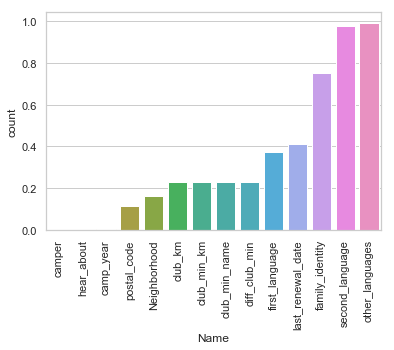

In [33]:
miss = miss.to_frame() # convert to a dataframe
miss.columns = ['count'] # rename the column as 'count'
miss.index.names = ['Name'] # rename index as 'Name'
miss['Name'] = miss.index # create a new column of the index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
plt.show()

Remove if exceeds 25%

In [34]:
droplist_missing = [i for i in df.columns if df[i].isnull().sum()/len(df[i]) > 0.25]
droplist_missing

['first_language',
 'second_language',
 'other_languages',
 'last_renewal_date',
 'family_identity']

### Feature Balance

Create a smaller subset of 

In [39]:
balance_check = [i for i in df.columns if df[i].nunique() < 50]
df_balance_check = df[balance_check]

df_balance_check.nunique()

label               2
first_year         10
mem_type            2
member_location     9
province            3
sex                 2
suspended           2
camper              2
camp_year           2
hear_about          2
Y1_Age             19
checkin_total      39
season_most         2
club_min_name      14
dtype: int64

Define a function to remove columns that have a value count exceeding 90%

In [40]:
def imbalanced_features(df_to_check, threshold = 0.9):
    """
    Returns a list of columns where at least one value count exceeds threshold
    """
    
    df_to_output = df_to_check
    
    for h in df_to_check.columns:
        col_val_count = pd.value_counts(df_to_check[h].values, sort=False)  # returns value counts by column
        
        count = 0
        
        for i in col_val_count.values:
            if i / df_to_check.shape[0] > threshold:
                count += 1
        
        if count > 0:
            df_to_output = df_to_output.drop(h, axis = 1)
            
    list_to_output = df_to_check.drop(df_to_output.columns, axis = 1).columns
            
    return list_to_output

Use function to create list of imbalanced features

In [41]:
imbalance = imbalanced_features(df_balance_check, 0.82)
imbalance

Index(['mem_type', 'province', 'suspended', 'camper', 'camp_year',
       'hear_about'],
      dtype='object')

Update df by dropping imbalanced features

In [42]:
categorical_features = df_balance_check.drop(imbalance, axis = 1).columns

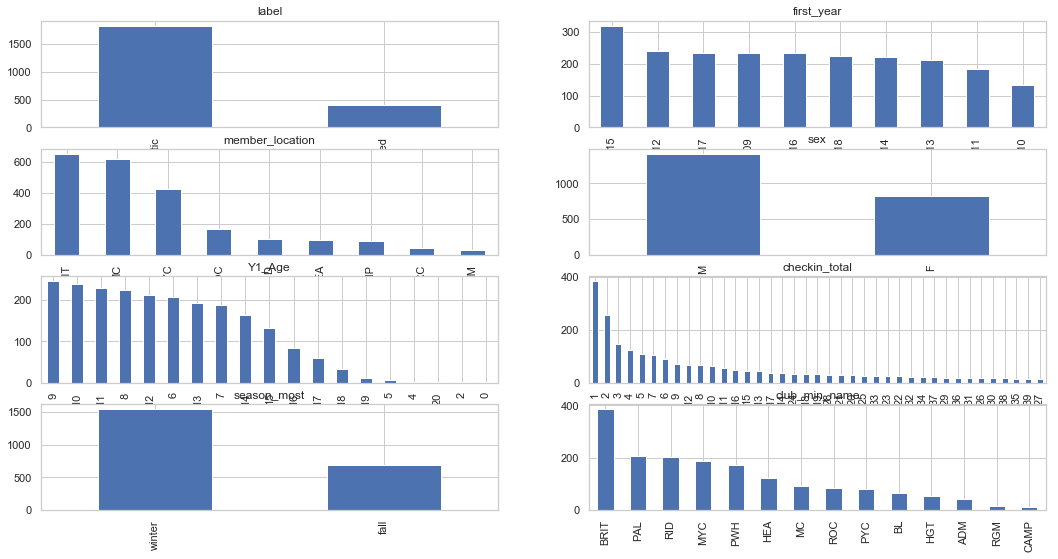

In [43]:
# plot parameters
ROWS, COLS = 4, 2  # set number of rows and columns for figures

fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 9))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)

### Transformations: Skewed data

In [ ]:
df['checkin_total'] = pd.qcut(df['checkin_total'], 4, labels = ('D', 'C', 'B', 'A'))

df.head()